In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import *
from keras.applications.vgg16 import VGG16

import pickle
import cv2
sns.set_style("darkgrid")

2024-12-20 22:44:49.793498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 22:44:50.520846: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 22:44:51.779753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/abdo/miniconda3/envs/tf/lib/
2024-12-20 22:44:51.780624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
# generators

train_ds = keras.utils.image_dataset_from_directory(
    directory = 'Data/zoz/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = 'Data/zoz/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.


2024-12-20 22:47:03.323620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-20 22:47:03.433733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-20 22:47:03.433849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-20 22:47:03.439648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Found 5000 files belonging to 2 classes.


In [3]:
def process(image, label):
    image = tf.cast(image/255.,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [8]:
def predict_vgg(test_img):
    
    test_img = cv2.resize(test_img,(150,150))
    test_input = test_img.reshape((1,150,150,3))
    
    predictions_vgg = vgg.predict(test_input)
    
    if predictions_vgg[0][0] > 0.5:
        print("Prediction: Dog")
    else:
        print("Prediction: Cat")

    plt.imshow(test_img)
    plt.show()

In [9]:
conv_base = VGG16(weights = "imagenet",
                 include_top = False,     # removing FC Layers
                 input_shape = (150,150,3)
                 )

58889256/58889256 [==============================] - 20s 0us/step


In [10]:
vgg = Sequential()

vgg.add(conv_base)
vgg.add(Flatten())


vgg.add(Dense(512, kernel_initializer='he_normal', activation='relu'))
vgg.add(Dropout(0.2))
vgg.add(Dense(256, kernel_initializer='he_normal', activation='relu'))
vgg.add(Dropout(0.2))
vgg.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
vgg.add(Dropout(0.2))
vgg.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
vgg.add(Dropout(0.2))
vgg.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))


vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)              

In [11]:
conv_base.trainable = False

In [14]:
batch_size = 32

train_dg = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True)
test_dg = ImageDataGenerator(rescale = 1./255)

train_gen = train_dg.flow_from_directory('Data/zoz/train',
                                        target_size = (150,150),
                                        batch_size = batch_size,
                                        class_mode = "binary")

test_gen = test_dg.flow_from_directory('Data/zoz/test',
                                        target_size = (150,150),
                                        batch_size = batch_size,
                                        class_mode = "binary")

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [15]:
vgg.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [16]:
history2 = vgg.fit_generator(train_gen,
                            epochs=20,
                            validation_data = test_gen,
                            callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
                                       keras.callbacks.ModelCheckpoint('cat_dog.h5', save_best_only=True, monitor='val_loss')])
                            

Epoch 1/20


2024-12-20 23:07:26.332869: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-20 23:07:26.334005: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-20 23:07:26.908590: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-20 23:07:26.908664: W tensorflow/core/common_runtime/bfc_allocato

625/625 [==============================] - 252s 398ms/step - loss: 0.3566 - accuracy: 0.8411 - val_loss: 0.2581 - val_accuracy: 0.8824
Epoch 2/20
625/625 [==============================] - 206s 329ms/step - loss: 0.2672 - accuracy: 0.8884 - val_loss: 0.2160 - val_accuracy: 0.9008
Epoch 3/20
625/625 [==============================] - 202s 323ms/step - loss: 0.2451 - accuracy: 0.8968 - val_loss: 0.1995 - val_accuracy: 0.9162
Epoch 4/20
625/625 [==============================] - 204s 326ms/step - loss: 0.2298 - accuracy: 0.9056 - val_loss: 0.2002 - val_accuracy: 0.9122
Epoch 5/20
625/625 [==============================] - 201s 322ms/step - loss: 0.2244 - accuracy: 0.9051 - val_loss: 0.1916 - val_accuracy: 0.9146
Epoch 6/20
625/625 [==============================] - 203s 324ms/step - loss: 0.2197 - accuracy: 0.9086 - val_loss: 0.2001 - val_accuracy: 0.9130
Epoch 7/20
625/625 [==============================] - 201s 322ms/step - loss: 0.2045 - accuracy: 0.9146 - val_loss: 0.2139 - val_accura

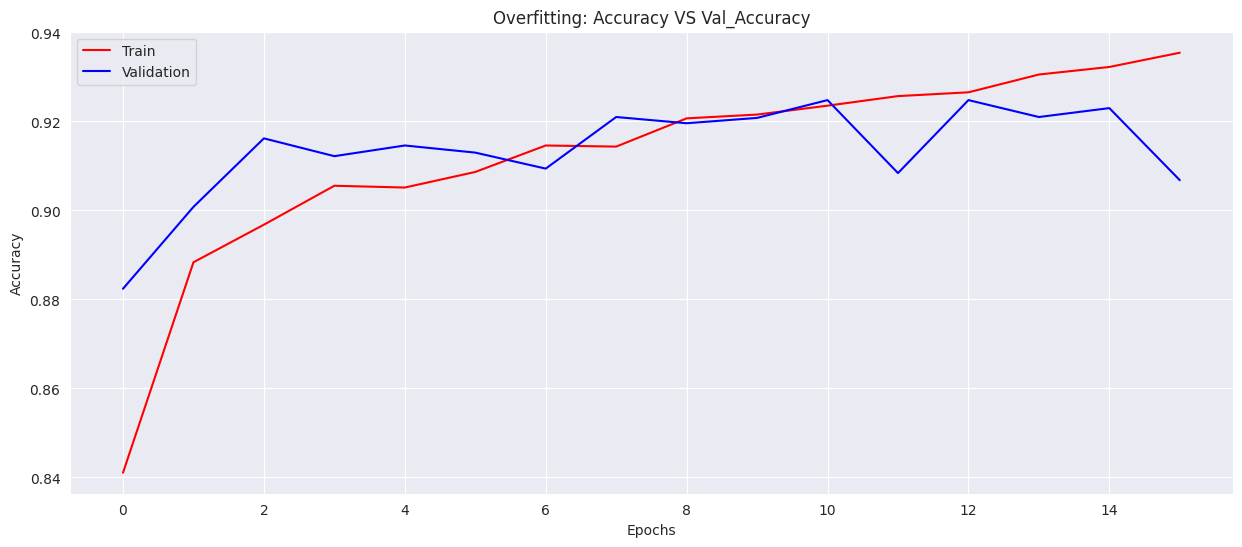

In [17]:
plt.figure(figsize=(15,6))
plt.plot(history2.history["accuracy"],color = "red",label = "Train")
plt.plot(history2.history["val_accuracy"],color = "blue", label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Overfitting: Accuracy VS Val_Accuracy")
plt.legend()
plt.show()


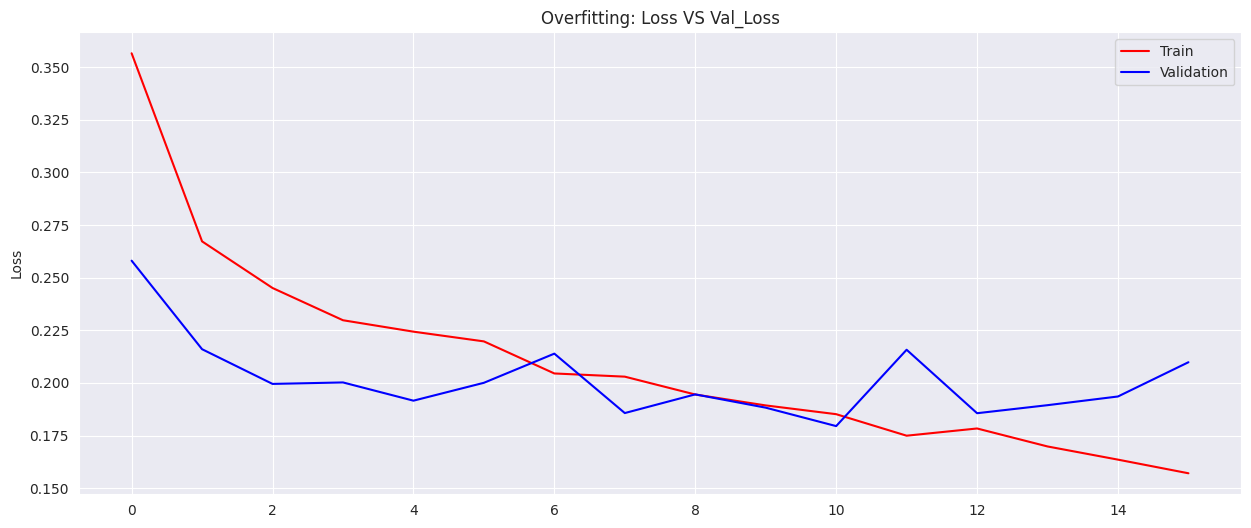

In [18]:
plt.figure(figsize=(15,6))
plt.plot(history2.history["loss"],color = "red",label = "Train")
plt.plot(history2.history["val_loss"],color = "blue", label = "Validation")
plt.ylabel("Loss")
plt.title("Overfitting: Loss VS Val_Loss")
plt.legend()
plt.show()



1/1 [==============================] - 1s 1s/step
Prediction: Cat


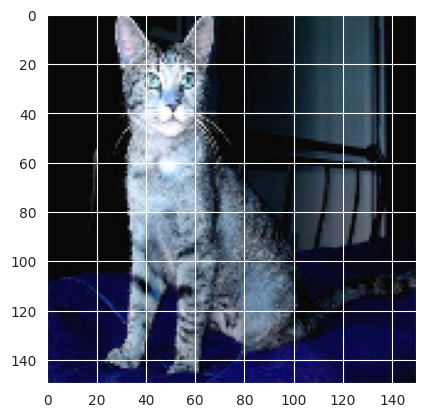

In [20]:
test_img = cv2.imread('Data/zoz/test/cats/cat.10000.jpg')  # cat image new data 
predict_vgg(test_img)

1/1 [==============================] - 0s 29ms/step
Prediction: Dog


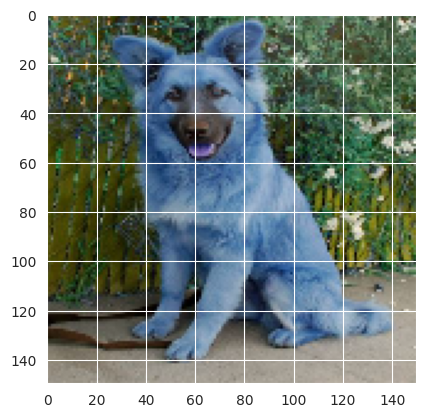

In [21]:
test_img = cv2.imread('Data/zoz/test/dogs/dog.10014.jpg')  # dog image new data 
predict_vgg(test_img)

157/157 [==============================] - 31s 194ms/step


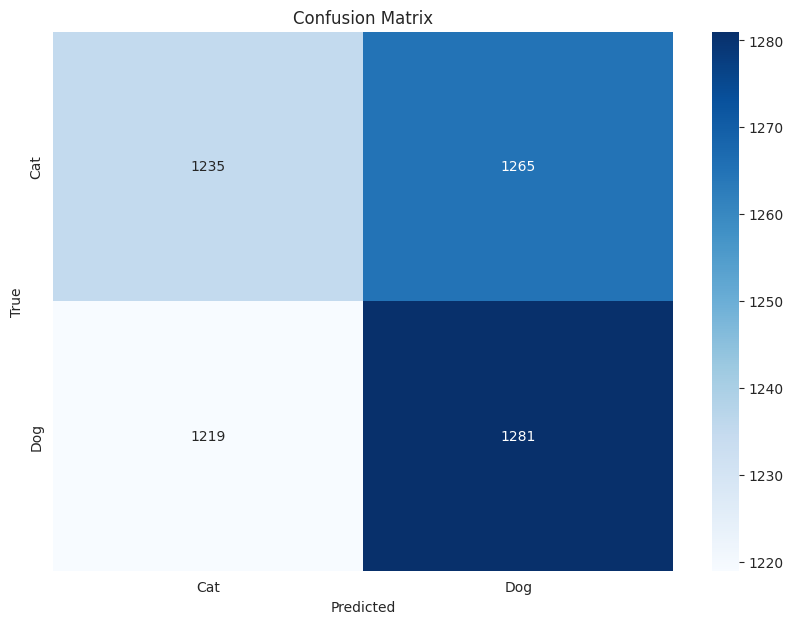

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
y_pred = vgg.predict(test_gen)
y_pred_classes = np.where(y_pred > 0.5, 1, 0).flatten()

# Get true labels
y_true = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=['Cat', 'Dog'])
print(report)

              precision    recall  f1-score   support

         Cat       0.50      0.49      0.50      2500
         Dog       0.50      0.51      0.51      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



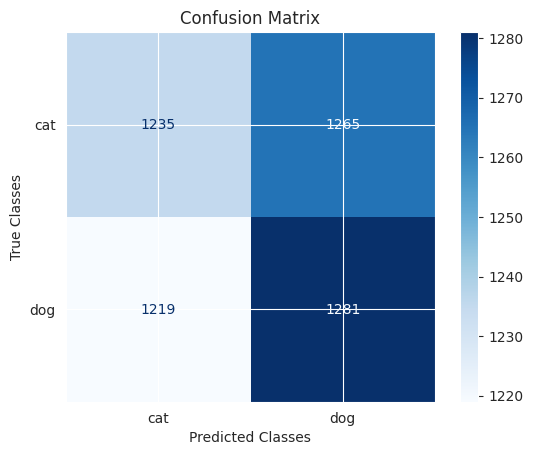

In [27]:


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use y_true as y_test
y_test = y_true

# Convert y_test to numerical labels (0 for 'cat', 1 for 'dog')
y_test_numeric = y_test

# Convert pred to binary predictions (0 or 1) using a threshold
pred_binary = (y_pred > 0.5).astype(int).flatten()  # You can adjust the threshold if needed

# Now, create the confusion matrix
cm = confusion_matrix(y_test_numeric, pred_binary)

# Define your class names (matching the numerical labels)
class_names = ['cat', 'dog']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Change the color to blue
disp.plot(cmap='Blues')

plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')

plt.show()